<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Check-structure-relaxation-of-LAMMPS-inside-ASE" data-toc-modified-id="Check-structure-relaxation-of-LAMMPS-inside-ASE-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Check structure relaxation of LAMMPS inside ASE</a></span></li><li><span><a href="#Create-training:-rattled-atoms-of-bulk,-vac-in-bulk,-cell-deformation-of-bulk-and-unrelaxed-of-structures-of-bulk-and-vacancy" data-toc-modified-id="Create-training:-rattled-atoms-of-bulk,-vac-in-bulk,-cell-deformation-of-bulk-and-unrelaxed-of-structures-of-bulk-and-vacancy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create training: rattled atoms of bulk, vac in bulk, cell deformation of bulk and unrelaxed of structures of bulk and vacancy</a></span></li><li><span><a href="#Phonon-example" data-toc-modified-id="Phonon-example-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Phonon example</a></span></li><li><span><a href="#Old-example:-rattling-each-atom-in-one-direction-and-adding-it-to-training" data-toc-modified-id="Old-example:-rattling-each-atom-in-one-direction-and-adding-it-to-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Old example: rattling each atom in one direction and adding it to training</a></span></li><li><span><a href="#Test-potential-with-LAMMPS" data-toc-modified-id="Test-potential-with-LAMMPS-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test potential with LAMMPS</a></span></li><li><span><a href="#test-vacancy-migration-in-LAMMPS" data-toc-modified-id="test-vacancy-migration-in-LAMMPS-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>test vacancy migration in LAMMPS</a></span></li><li><span><a href="#Deformation-matrices-from-Holec-et-al." data-toc-modified-id="Deformation-matrices-from-Holec-et-al.-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Deformation matrices from Holec et al.</a></span></li><li><span><a href="#Pymatgen-example" data-toc-modified-id="Pymatgen-example-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Pymatgen example</a></span></li></ul></div>

In [ ]:
!wget https://www.ctcms.nist.gov/potentials/Download/2001--Mishin-Y-Mehl-M-J-Papaconstantopoulos-D-A-et-al--Cu-1/2/Cu01.eam.alloy

##  Check structure relaxation of LAMMPS inside ASE

In [ ]:
from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.emt import EMT
import numpy as np
d = 0.9575
t = np.pi / 180 * 104.51
water = Atoms('H2O',
              positions=[(d, 0, 0),
                         (d * np.cos(t), d * np.sin(t), 0),
                         (0, 0, 0)],
              calculator=EMT())
dyn = BFGS(water)
dyn.run(fmax=0.05)

## Create training: rattled atoms of bulk, vac in bulk, cell deformation of bulk and unrelaxed of structures of bulk and vacancy

In [22]:
import numpy as np
from ase.io.extxyz import write_extxyz
from ase import Atom, Atoms
from ase.build import bulk
from ase.calculators.lammpsrun import LAMMPS
import os
! rm master*
sdev_disp = 0.005
os.chdir('/home/hari/projects/developing_ACE/ACE1project/EAM-alloy-vac')
parameters = {"pair_style": "eam/alloy", "pair_coeff": ["* * Cu01.eam.alloy Cu"]}
files = ["Cu01.eam.alloy"]
Cu = bulk("Cu", cubic=True, a=3.615).repeat(4)
lammps = LAMMPS(parameters=parameters, files=files)
n_atoms = Cu.get_number_of_atoms()
energies_bulk = []
energies_vac = []
energy_cell_shape = []
for i in np.arange(0, 50):
    Cu_rattle = Cu.copy()
    Cu_rattle.rattle(stdev=sdev_disp, seed=np.random.randint(low=100, high=500))
    Cu_rattle.calc = lammps
    Cu_rattle.info = {"config_type": "bulk", "stress": Cu_rattle.get_stress()}
    write_extxyz(fileobj="bulk.xyz", images=Cu_rattle)
    filenames = ["bulk.xyz"]
    with open("master.xyz", "a") as outfile:
        for fname in filenames:
            with open(fname) as infile:
                outfile.write(infile.read())
    energies_bulk.append(Cu_rattle.get_potential_energy())

#!rm master*

parameters = {"pair_style": "eam/alloy", "pair_coeff": ["* * Cu01.eam.alloy Cu"]}
files = ["Cu01.eam.alloy"]
Cu = bulk("Cu", cubic=True, a=3.615).repeat(4)
Cu.pop(0)
lammps = LAMMPS(parameters=parameters, files=files)
n_atoms = Cu.get_number_of_atoms()

for i in np.arange(0, 50):
    Cu_rattle = Cu.copy()
    Cu_rattle.rattle(stdev=sdev_disp, seed=np.random.randint(low=100, high=500))
    Cu_rattle.calc = lammps
    Cu_rattle.info = {"config_type": "bulk", "stress": Cu_rattle.get_stress()}
    write_extxyz(fileobj="bulk.xyz", images=Cu_rattle)
    filenames = ["bulk.xyz"]
    with open("master.xyz", "a") as outfile:
        for fname in filenames:
            with open(fname) as infile:
                outfile.write(infile.read())
    energies_vac.append(Cu_rattle.get_potential_energy())

Cu = bulk("Cu", cubic=True, a=3.615).repeat(4)
lammps = LAMMPS(parameters=parameters, files=files)
Cu.calc = lammps
Cu.info = {"config_type": "bulk", "stress": Cu.get_stress()}
write_extxyz(fileobj="bulk.xyz", images=Cu)
filenames = ["bulk.xyz"]
with open("master.xyz", "a") as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())
energy_bulk = Cu.get_potential_energy()
Cu_vac = bulk("Cu", cubic=True, a=3.615).repeat(4)
lammps = LAMMPS(parameters=parameters, files=files)
Cu_vac.pop(0)
Cu_vac.calc = lammps
Cu_vac.info = {"config_type": "bulk", "stress": Cu_vac.get_stress()}
write_extxyz(fileobj="bulk.xyz", images=Cu_vac)
filenames = ["bulk.xyz"]
with open("master.xyz", "a") as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())
Cu = bulk("Cu", cubic=False, a=3.615)
energy_vac = Cu_vac.get_potential_energy()
for i in np.arange(0,50):
    Cu_rattle = Cu.copy()
    A = Cu.cell @ np.identity(3)
    A = A @ (np.identity(3) + 0.05 * (np.random.rand(3,3) - 0.5))
    Cu_rattle.set_cell(A,scale_atoms=True)
    Cu_rattle.calc = lammps
    Cu_rattle.info = {"config_type": "cell_deform", "stress": Cu_rattle.get_stress()}
    write_extxyz(fileobj="bulk.xyz", images=Cu_rattle)
    filenames = ["bulk.xyz"]
    with open("master.xyz", "a") as outfile:
        for fname in filenames:
            with open(fname) as infile:
                outfile.write(infile.read())
    energy_cell_shape.append(Cu_rattle.get_potential_energy())
! rm bulk.xyz

/home/hari/miniconda3/envs/ase_env/lib/python3.7/site-packages/ase/calculators/lammpsrun.py:191: UserWarning: You are using an old syntax to set 'parameters'.
Please use LAMMPSRUN.set().
  warnings.warn(self.legacy_warn_string.format("parameters"))
/home/hari/miniconda3/envs/ase_env/lib/python3.7/site-packages/ase/atoms.py:968: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)
/home/hari/miniconda3/envs/ase_env/lib/python3.7/site-packages/ase/calculators/lammpsrun.py:191: UserWarning: You are using an old syntax to set 'parameters'.
Please use LAMMPSRUN.set().
  warnings.warn(self.legacy_warn_string.format("parameters"))
/home/hari/miniconda3/envs/ase_env/lib/python3.7/site-packages/ase/atoms.py:968: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)
/home/hari/miniconda3/envs/ase_env/lib/python3.7/site-packages/ase/calculators/lammpsrun.py:191: UserWarning: You are using an old syntax to

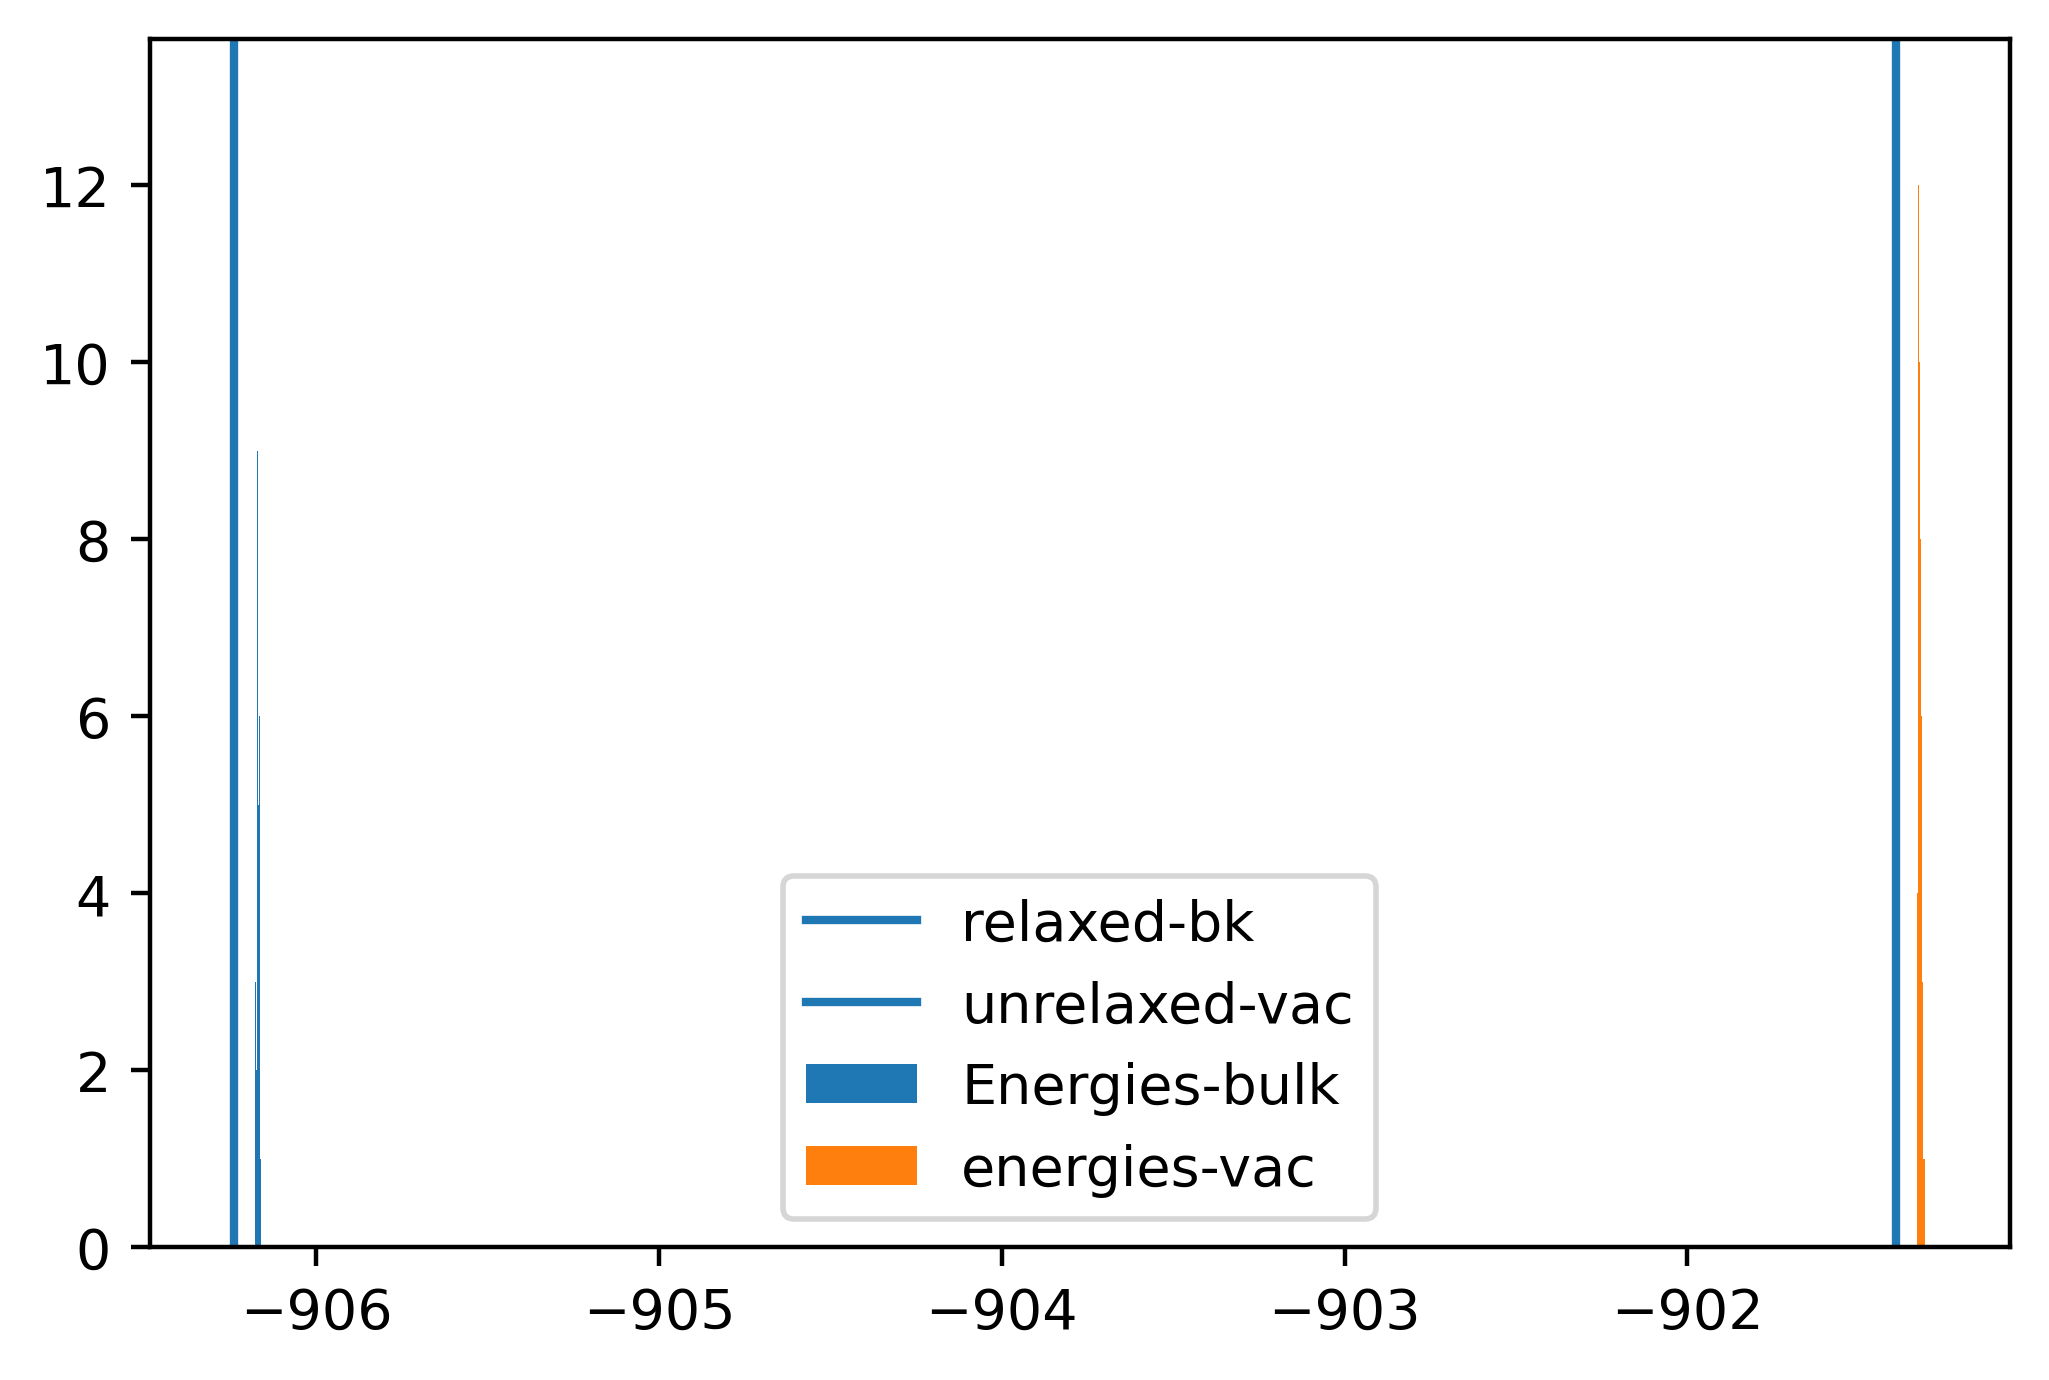

In [23]:
from matplotlib import pyplot as plt
plt.figure(dpi=400)
plt.hist(energies_bulk, bins=10,label='Energies-bulk')
plt.axvline(energy_bulk,label='relaxed-bk')
plt.hist(energies_vac, bins=10,label='energies-vac')
plt.axvline(energy_vac,label='unrelaxed-vac')
plt.legend()

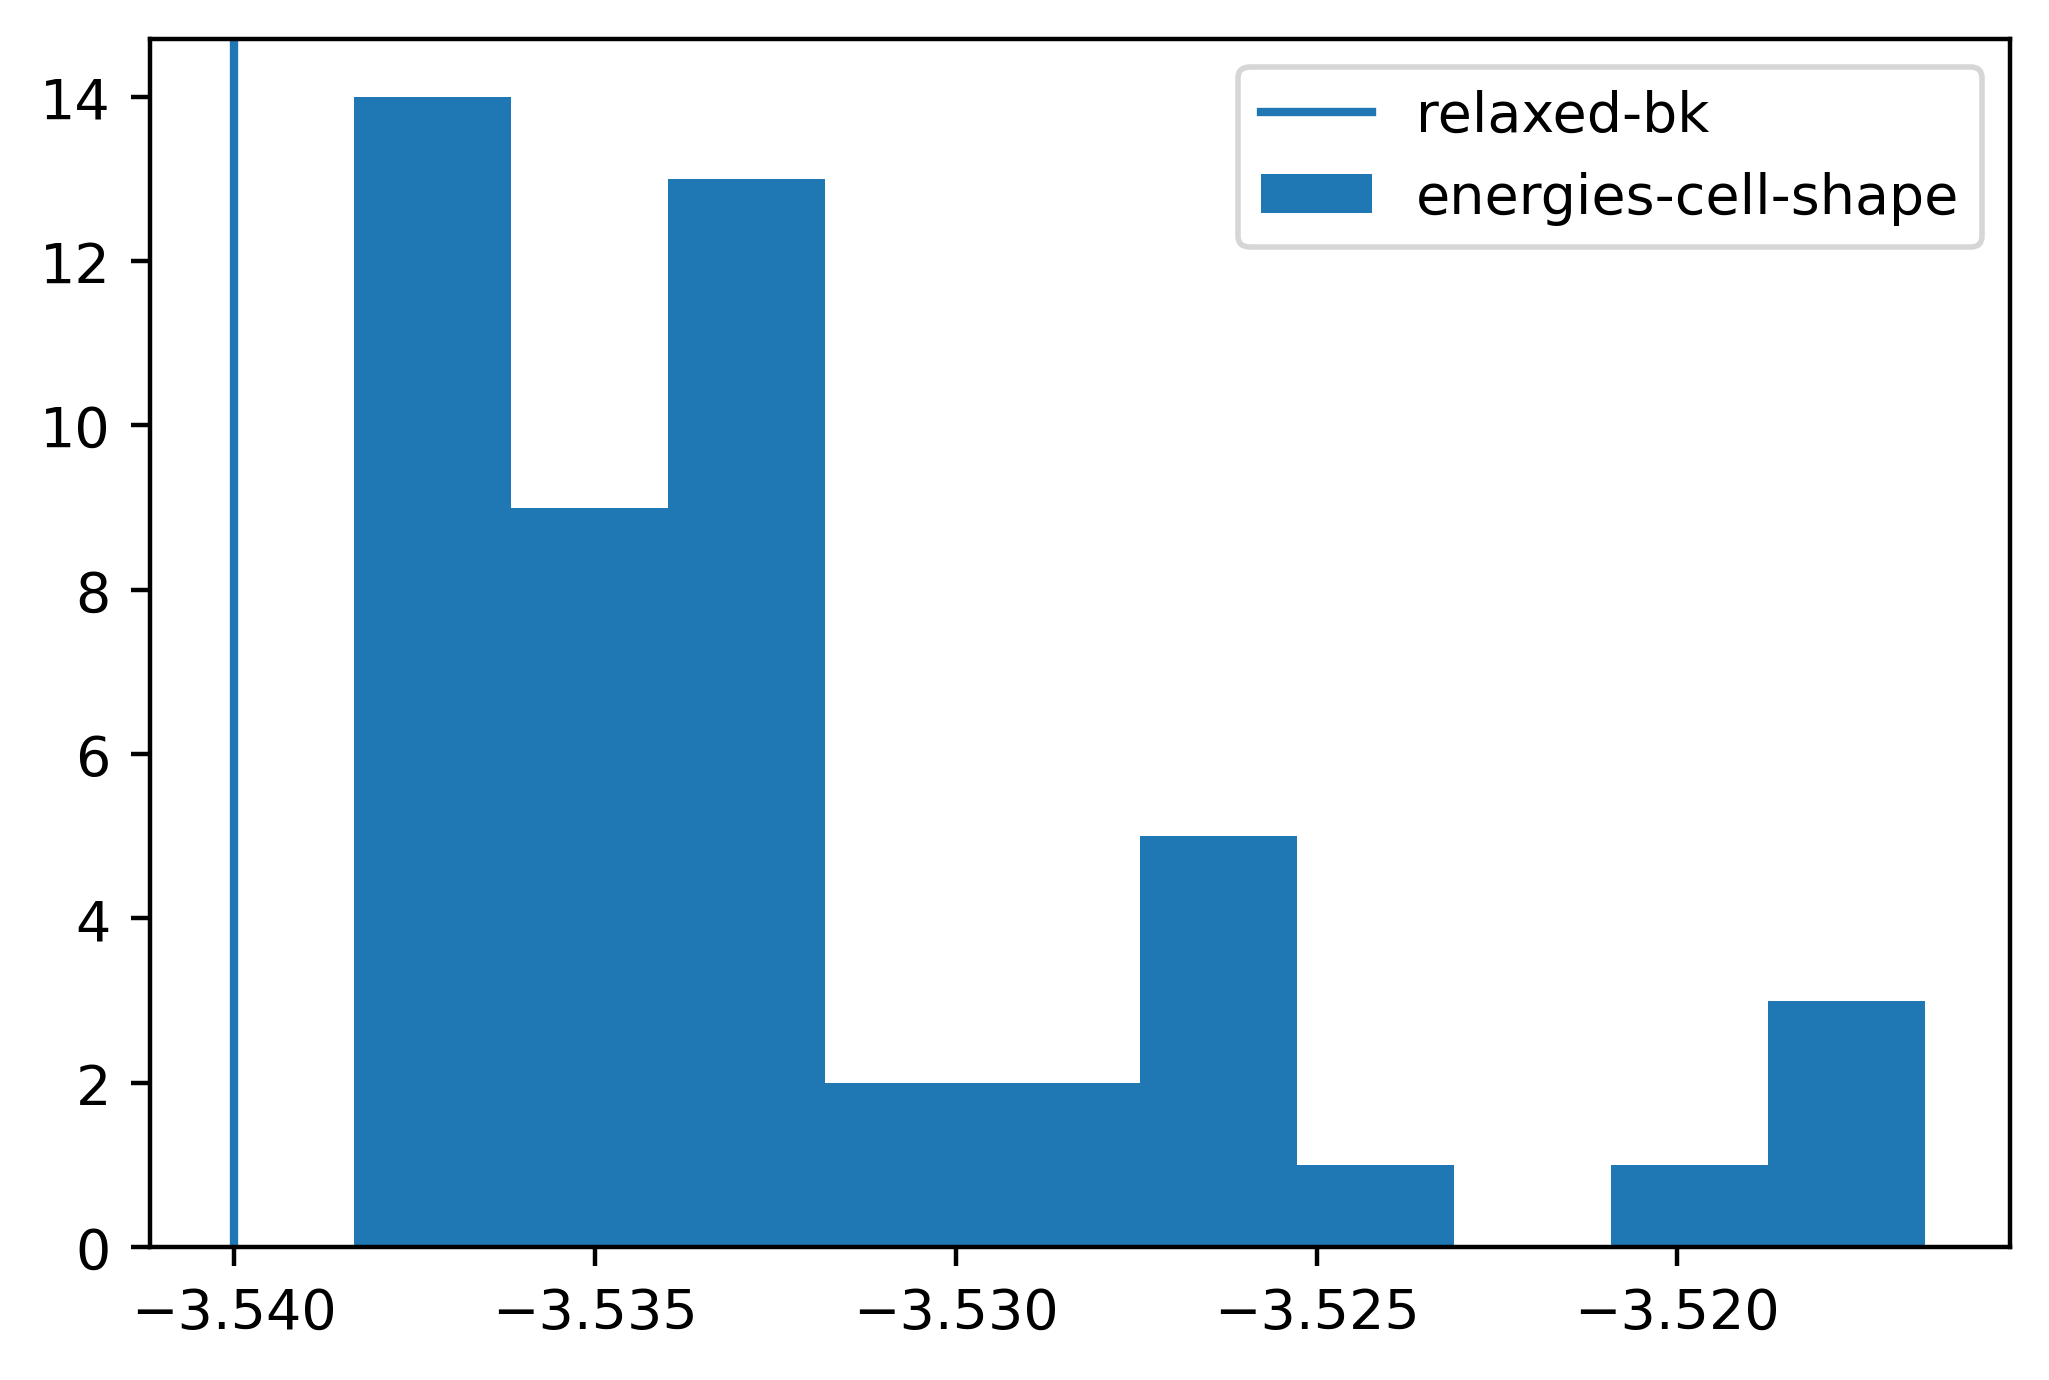

In [24]:
plt.figure(dpi=400)
plt.hist(energy_cell_shape, bins=10,label='energies-cell-shape')
plt.axvline(energy_bulk/256,label='relaxed-bk')
plt.legend()

In [25]:
!julia acefit.jl

[ Info: Assembling linear problem.
[ Info:   - Creating feature matrix with size (79397, 31).
[ Info:   - Beginning assembly in serial mode.
Progress: 100%|█████████████████████████████████████████| Time: 0:02:25
[ Info:   - Assembly completed.
┌ Warning: Need to apply preconditioner in LSQR.
└ @ ACEfit ~/miniconda3/envs/ase_env/share/julia/packages/ACEfit/L0tz0/src/solvers.jl:121
damp  0.01
atol  1.0e-6
maxiter  100000
Converged after 12 iterations.
relative RMS error  0.811901663860533
[ Info: Training Error Table
[ Info: RMSE Table
┌─────────────┬─────────┬──────────┬─────────┐
│        Type │ E [meV] │ F [eV/A] │ V [meV] │
├─────────────┼─────────┼──────────┼─────────┤
│        bulk │   0.762 │    0.045 │   0.076 │
│ cell_deform │   8.826 │    0.000 │  72.211 │
├─────────────┼─────────┼──────────┼─────────┤
│         set │   5.100 │    0.045 │  41.416 │
└─────────────┴─────────┴──────────┴─────────┘
[ Info: MAE Table
┌─────────────┬─────────┬──────────┬─────────┐
│        Type │ E 

In [ ]:
data = []
for i in np.linspace(start=3.57, stop=3.63, num=10):
    Cu = bulk("Cu", cubic=True, a=i).repeat(10)
    N_at = Cu.get_number_of_atoms()
    lammps = LAMMPS(parameters=parameters, files=files)
    Cu.calc = lammps
    vol = Cu.get_volume()/N_at
    Cu_vac = bulk("Cu", cubic=True, a=i).repeat(10)
    lammps = LAMMPS(parameters=parameters, files=files)
    Cu_vac.pop(0)
    Cu_vac.calc = lammps
    e_vac_f = Cu_vac.get_potential_energy() - (N_at -1)/N_at* Cu.get_potential_energy()
    data.append([vol, e_vac_f])

In [ ]:
import pandas as pd

df_data = pd.DataFrame(data, columns=['volume','e_vac_formation'])

plt.plot(df_data['volume'], df_data['e_vac_formation'], '*')

data

## Phonon example

In [ ]:
from ase.calculators.lammpslib import LAMMPSlib

cmds = ["pair_style eam/alloy",
        "pair_coeff * * Cu01.eam.alloy Cu"]

Cu_check = bulk('Cu', cubic=True)

lammps = LAMMPSlib(lmpcmds=cmds, log_file='test.log')
Cu_check.calc = lammps
Cu_check.get_potential_energy()

In [ ]:
from ase.build import bulk
from ase.calculators.emt import EMT
from ase.phonons import Phonons

# Setup crystal and calculator
atoms = bulk('Cu', 'fcc', a=3.615)

# Phonon calculator
N = 7
ph = Phonons(atoms, EMT(), supercell=(N, N, N), delta=0.05)
ph.run()

# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

path = atoms.cell.bandpath('GXULGKG', npoints=500)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=500, width=5e-4)

# Plot the band structure and DOS:
import matplotlib.pyplot as plt  # noqa
fig = plt.figure(1, figsize=(7, 4))
ax = fig.add_axes([.12, .07, .67, .85])

emax = 0.05
bs.plot(ax=ax, emin=0.0, emax=emax)

dosax = fig.add_axes([.8, .07, .17, .85])
dosax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color='grey',
                   edgecolor='k', lw=1)

dosax.set_ylim(0, emax)
dosax.set_yticks([])
dosax.set_xticks([])
dosax.set_xlabel("DOS", fontsize=18)

fig.savefig('Cu_phonon.png')

## Old example: rattling each atom in one direction and adding it to training

In [ ]:
import numpy as np
from ase.io.extxyz import write_extxyz
from ase import Atom, Atoms
from ase.build import bulk
from ase.calculators.lammpsrun import LAMMPS

! rm master*

parameters = {"pair_style": "eam/alloy", "pair_coeff": ["* * Cu01.eam.alloy Cu"]}
files = ["Cu01.eam.alloy"]
Cu = bulk("Cu", cubic=False, a=3.615).repeat(4)
lammps = LAMMPS(parameters=parameters, files=files)
n_atoms = Cu.get_number_of_atoms()
energy = []
energy_vac = []
for i in np.arange(0, n_atoms):
    for j in np.arange(0, 3):
        Cu = bulk("Cu", cubic=False, a=3.615).repeat(4)
        Cu.calc = lammps
        Cu.positions[i][j] += np.random.rand() * 1e-1
        # print("Energy ", Cu.get_potential_energy())
        Cu.info = {"config_type": "bulk", "stress": Cu.get_stress()}
        write_extxyz(fileobj="bulk.xyz", images=Cu)
        filenames = ["bulk.xyz"]
        with open("master.xyz", "a") as outfile:
            for fname in filenames:
                with open(fname) as infile:
                    outfile.write(infile.read())
        energy.append(Cu.get_potential_energy())


from ase import Atom, Atoms
from ase.build import bulk
from ase.calculators.lammpsrun import LAMMPS


parameters = {"pair_style": "eam/alloy", "pair_coeff": ["* * Cu01.eam.alloy Cu"]}
files = ["Cu01.eam.alloy"]
Cu = bulk("Cu", cubic=False, a=3.615).repeat(4)
Cu.pop(0)
lammps = LAMMPS(parameters=parameters, files=files)
n_atoms = Cu.get_number_of_atoms()
for i in np.arange(0, n_atoms):
    for j in np.arange(0, 3):
        Cu = bulk("Cu", cubic=False, a=3.615).repeat(4)
        Cu.pop(0)
        Cu.calc = lammps
        Cu.positions[i][j] += np.random.rand() * 1e-1
        # print("Energy ", Cu.get_potential_energy())
        Cu.info = {"config_type": "vac", "stress": Cu.get_stress()}
        write_extxyz(fileobj="vac.xyz", images=Cu)
        filenames = ["vac.xyz"]
        with open("master_vac.xyz", "a") as outfile:
            for fname in filenames:
                with open(fname) as infile:
                    outfile.write(infile.read())
        energy_vac.append(Cu.get_potential_energy())


filenames = ["master.xyz", "master_vac.xyz"]
with open("master_full.xyz", "a") as outfile:
    for fname in filenames:
        with open(fname) as infile:
            outfile.write(infile.read())

In [ ]:
plt.hist(energy, bins=20)
plt.hist(energy_vac, bins=20)

In [ ]:
Cu = bulk("Cu", cubic=True, a=3.615).repeat(10)
N_at = Cu.get_number_of_atoms()
lammps = LAMMPS(parameters=parameters, files=files)
Cu.calc = lammps
Cu.get_potential_energy()
plt.hist(energy, bins=10)
plt.axvline(Cu.get_potential_energy())
plt.hist(energy_vac, bins=10)
plt.axvline(Cu_vac.get_potential_energy())

## Test potential with LAMMPS

In [ ]:
import os
os.chdir("lammps-test/vac_migration/")
os.chdir("../bulk_test/")
!./run.sh

In [ ]:
-905.26035374198/256

In [ ]:
os.chdir("../vac_migration/")

In [ ]:
!./run.sh

## test vacancy migration in LAMMPS

In [26]:
!cp potential* lammps-test/
os.chdir("lammps-test/vac_migration/")
os.chdir("../vac_test/")

In [27]:
!./run.sh

LAMMPS (22 Dec 2022)
Reading data file ...
  orthogonal box = (0 0 0) to (14.46 14.46 14.46)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  255 atoms
  read_data CPU = 0.001 seconds
ACE version: 2022.6.27
Recursive evaluator is used
Loading ../potential.yace
Total number of basis functions
	Cu: 6 (r=1) 23 (r>1)
Mapping LAMMPS atom type #1(Cu) -> ACE species type #0
Reading pair table potential file ../potential_pairpot.table with DATE: none
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 9
  ghost atom cutoff = 9
  binsize = 4.5, bins = 4 4 4
  2 neighbor lists, perpetual/occasional/extra = 2 0 0
  (1) pair pace, perpetual
      attributes: full, newton on, cut 7.506786
      pair build: full/bin/atomonly
      stencil: full/bin/3d
      bin: standard
  (2) pair table, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: h

        31                     0    -1126.55006276616    -1126.55006276616    -306913.429332701  1.7207699060242e-05 -1.14303451038865e-05    -306913.429332693 -1.54740874941398e-05    -306913.429332716          3023.464536
        32                     0    -1129.41517299991    -1129.41517299991    -331340.155763299 0.000414196687018681 -0.000275157282422662    -331340.155763214 -0.000372490819098601    -331340.155763455          3023.464536
        33                     0    -1162.06367919409    -1162.06367919409    -286644.440422704 -0.000405095552957721 0.000269096524708477    -286644.440422782 0.000364285952105037    -286644.440422569          3023.464536
        34                     0    -1179.38480711551    -1179.38480711551    -332785.358460614  0.00070025802301033 -0.00046518062758507    -332785.358460612 -0.000629731721712272    -332785.358460615          3023.464536
        35                     0    -1199.89869359159    -1199.89869359159    -375641.299301812 -0.0009102

        68                     0    -73708.7671212794    -73708.7671212794    -62618645.6898127     73.3893760785572    -60.0408548180218    -62618635.2104548    -87.8494096316631    -62618664.1800681          3023.464536
        69                     0    -1113493.30692806    -1113493.30692806     -469833295.75708    -662.066440471462     462.961105523643    -469833190.771999     639.843830545483    -469833480.980636          3023.464536
ERROR on proc 0: Pair distance < table inner cutoff: ijtype 1 1 dist 0.03886917871187267 (../pair_table.cpp:116)
Last command: minimize 	0.0 0.0001 100000 10000000
application called MPI_Abort(MPI_COMM_WORLD, 1) - process 0
[unset]: write_line error; fd=-1 buf=:cmd=abort exitcode=1
:
system msg for write_line failure : Bad file descriptor


In [ ]:
-906.0250770814/256

## Deformation matrices from Holec et al.

In [ ]:
delta = 0.343
orthorhombic_deform = np.array(
    ([delta, 0, 0], [0, -delta, 0], [0, 0, delta ** 2 / (1 - delta ** 2)])
)

monoclinic_deform = np.array(
    ([0, delta * 0.5, 0], [delta * 0.5, 0, 0], [0, 0, delta ** 2 / (4 - delta ** 2)])
)

tet_deform = np.array(([-delta * 0.5, 0, 0], [0, -delta * 0.5, 0], [0, 0, delta]))

triclinc_deform = np.array(([0, delta, 0], [delta, 0, 0], [0, 0, 0]))

a1 = np.array(([delta, 0, 0], [0, 0, 0], [0, 0, 0]))

a2 = np.array(([delta, 0, 0], [0, delta, 0], [0, 0, 0]))


np.matmul(tet_deform, Cu_primitive.cell)

np.matmul(orthorhombic_deform, Cu_primitive.cell)

Cu_primitive.cell / (3.615)

orthorhombic_deform

3.615 ** 3

1.9521 ** 2 * 3.9042 * 4

# orthorhombic_deform.transpose()  @ Cu_primitive.cell/(3.615) @ orthorhombic_deform
l = Cu_primitive.cell @ tet_deform

l

np.dot(np.cross(l[0], l[1]), l[2])

a3 = np.array(([delta, 0, 0], [0, delta, 0], [0, 0, delta]))
a4 = np.array(([delta, 0, 0], [0, 0, delta], [0, delta, 0]))
a5 = np.array(([delta, delta, 0], [delta, 0, 0], [0, 0, 0]))
a5 = np.array(([0, delta, delta], [delta, 0, delta], [delta, delta, 0]))

np.dot(np.cross(Cu_primitive.cell[0], Cu_primitive.cell[1]), Cu_primitive.cell[2])

## Pymatgen example

In [ ]:
from pymatgen.core import Structure
from pymatgen.core import Lattice
from pymatgen.transformations.advanced_transformations import CubicSupercellTransformation

In [ ]:
struct = Structure.from_spacegroup('P6/mmm',
                                  Lattice.hexagonal(2.46,5.4),
                                  ['C'],
                                  [[1/3,2/3,1/2]])
tmfs = CubicSupercellTransformation().apply_transformation(struct)


In [ ]:
struct

In [ ]:
tmfs